In [182]:
import matplotlib.pyplot as plt

In [183]:
g = 1

In [184]:
# Константы
# Время моделирования
T = 20
# Delta t
dt = 0.01

# Заданные параметры
T_ob = 1
Xi = 0.75
K_ob = 1
# Время запаздывания
tau_ob = 0.1

In [185]:
class AdjustableModule:
    '''Объект регулирования'''
    y_1 = 0
    y_2 = 0

    def calc_output(self, input_value: float):
        y_1 = self.y_1
        y_2 = self.y_2
        k_1 = dt * (y_2)
        m_1 = dt * ((-2*Xi/T_ob)*y_2 - 1/(T_ob**2)*y_1 + K_ob/T_ob*input_value)
        k_2 = dt * (y_2 + k_1 / 2)
        m_2 = dt * ((-2*Xi/T_ob)*(y_2 + m_1/2) - 1/(T_ob**2)*(y_1 + k_1/2) + K_ob/T_ob*input_value)
        k_3 = dt * (y_2 + k_2 / 2)
        m_3 = dt * ((-2*Xi/T_ob)*(y_2 + m_2/2) - 1/(T_ob**2)*(y_1 + k_2/2) + K_ob/T_ob*input_value)
        k_4 = dt * (y_2 + k_3)
        m_4 = dt * ((-2*Xi/T_ob)*(y_2 + m_3) - 1/(T_ob**2)*(y_1 + k_3) + K_ob/T_ob*input_value)
        
        y_1 += (1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
        y_2 += (1/6) * (m_1 + 2*m_2 + 2*m_3 + m_4)
        self.y_1 = y_1
        self.y_2 = y_2

        output = y_1
        return output

In [186]:
t_vals = []
t = 0
y = []

ob = AdjustableModule()

while t < T:
    output = ob.calc_output(input_value=g)
    y.append(output)
    t_vals.append(t)
    t += dt

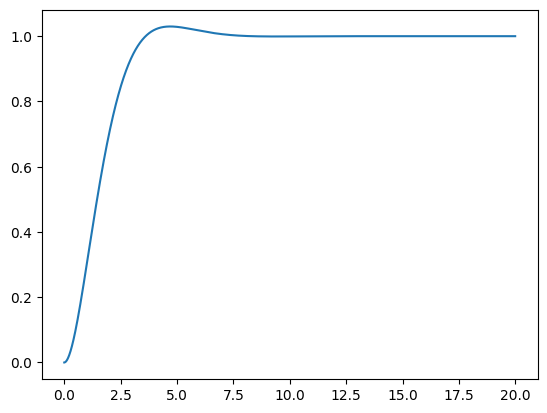

In [187]:
plt.plot(t_vals, y)

Теперь, пусть выход объекта регулирования - $` u(t) `$

In [188]:
u_values = []

Добавим звено запаздывания

In [189]:
class DelayModule:
    input_values = []

    def __init__(self, tau: float):
        self.tau = tau
        self.shift = int(tau / dt)

    def calc_output(self, input_value):
        self.input_values.append(input_value)
        if len(self.input_values) < self.shift:
            return 0
        return self.input_values[len(self.input_values) - self.shift]

In [ ]:
t_vals = []
t = 0
y_values = []

ob = AdjustableModule()
delay_module = DelayModule(tau=tau_ob)

while t < T:
    # Обратная связь
    x = g - y_val
    u_val = ob.calc_output(input_value=x)
    u_values.append(u_val)
    y_val = delay_module.calc_output(input_value=u_val)
    y_values.append(y_val)
    t_vals.append(t)
    t += dt

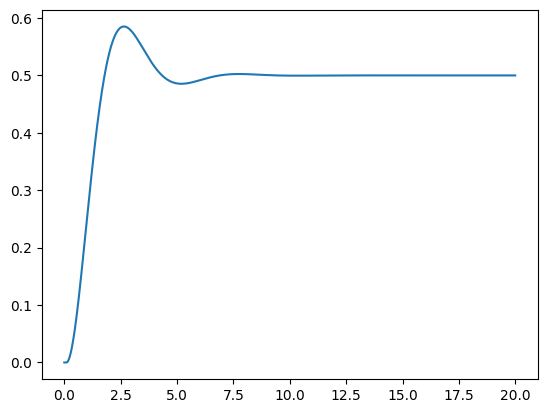

In [191]:
plt.plot(t_vals, y_values)
plt.show()

Добавим звено регулирования

In [ ]:
class ControlLink:
    def __init__(self, q_1, q_2, q_3):
        self.q_1 = q_1
        self.q_2 = q_2
        self.q_3 = q_3

    def calc_output(self, input_value):
        pass